## Imports

In [308]:
# Importing machine learning algorithms
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Importing other packages
import timeit
import pandas as pd
import numpy as np
import neptune
import tempfile


import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import my_functions as mf

import mlflow
import mlflow.catboost
import os


# Importing packages for machine learning operations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score


import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"

## Start Experiment

In [309]:
# mlflow.set_tracking_uri("https://dagshub.com/gfragi/PriceIndex.mlflow")


# Set the experiment name in MLflow
instance_Family = 'Compute_optimized'

mlflow.set_experiment(f'{instance_Family}_instanceSize')

<Experiment: artifact_location='file:///home/gfragi/Phd_projects/PriceIndex/catboost/mlruns/880218567274881853', creation_time=1685536556096, experiment_id='880218567274881853', last_update_time=1685536556096, lifecycle_stage='active', name='Compute_optimized_instanceSize', tags={}>

### Add some experiment tags

In [310]:
# 16xlarge    3144
# 4xlarge     3144
# xlarge      3144
# 8xlarge     3136
# 2xlarge     3136
# 12xlarge    2512
# 24xlarge    1600
# 48xlarge     720


instanceSize = "c5d.18xlarge"
# Set tags for the run
tags = {
    "experiment": "catboost_regression",
    "model_type": "CatBoostRegressor",
    "task_type": "CPU",
    "dataset": "Amazon",
    "year to predict": "2022",
    "all years for prediction": "no",
    "instanceSize": instanceSize
}

# Set the tags for the current run
mlflow.set_tags(tags)

In [311]:
mlflow.end_run()

## Import data 

In [312]:

data_all = pd.read_csv(
    f'../data/instFamily_subsets/{instance_Family}_subset.csv', parse_dates=['EffectiveDate'])

# data = data.drop(['OfferTermCode', 'instanceType', 'instanceFamily', 'OfferingClass'], axis=1)

data_all = data_all.drop(
    ['OfferTermCode', 'instanceFamily', 'year', 'Tenancy', 'OfferingClass'], axis=1)

In [313]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68120 entries, 0 to 68119
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   PricePerUnit         68120 non-null  float64       
 1   instanceType         68120 non-null  object        
 2   LeaseContractLength  68120 non-null  int64         
 3   PurchaseOption       68120 non-null  object        
 4   Location             68120 non-null  object        
 5   vCPU                 68120 non-null  int64         
 6   Memory               68120 non-null  int64         
 7   operatingSystem      68120 non-null  object        
 8   networkPerformance   68120 non-null  float64       
 9   EffectiveDate        68120 non-null  datetime64[ns]
 10  DiskType             68120 non-null  object        
 11  StorageSize          68120 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 6.2+ MB


In [314]:
# # replace USEast and USWest to US and EU to Europe
data_all = data_all.replace({'USEast': 'US', 'USWest': 'US', 'EU': 'Europe'})
data_all = data_all[(data_all['Location'] != "Africa") & (data_all['Location'] != "MiddleEast") & (data_all['Location']
                                                                                                   != "Canada") & (data_all['Location'] != "SouthAmerica") & (data_all['Location'] != "AWSGovCloud")]

In [315]:
# # create several new date time features
data_all['year'] = data_all['EffectiveDate'].dt.year
# data['day_of_year'] = data['EffectiveDate'].dt.dayofyear
# data['weekday'] = data['EffectiveDate'].dt.weekday
# data['week_of_year'] = data['EffectiveDate'].dt.week
# data['day_of_month'] = data['EffectiveDate'].dt.day
# data['quarter'] = data['EffectiveDate'].dt.quarter

# data.drop('EffectiveDate', axis=1, inplace=True)

In [316]:
data_all = data_all.drop(['Location'], axis=1)

### Sort 

In [317]:
data_all.sort_values(by='EffectiveDate')
data_all.reset_index(drop=True)

,PricePerUnit,instanceType,LeaseContractLength,PurchaseOption,vCPU,Memory,operatingSystem,networkPerformance,EffectiveDate,DiskType,StorageSize,year
0,0.885,c5d.xlarge,3,Partial Upfront,4,8,Windows,10.0,2020-04-01,NVMe SSD,100,2020
1,1.816,c5d.xlarge,1,No Upfront,4,8,Windows,10.0,2020-04-01,NVMe SSD,100,2020
2,1.835,c5d.xlarge,1,No Upfront,4,8,Windows,10.0,2018-04-30,NVMe SSD,100,2018
3,1.776,c5d.xlarge,3,No Upfront,4,8,Windows,10.0,2020-04-01,NVMe SSD,100,2020
4,0.914,c5d.xlarge,1,Partial Upfront,4,8,Windows,10.0,2018-04-30,NVMe SSD,100,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
54163,0.147,c5ad.xlarge,3,No Upfront,4,8,Linux,10.0,2020-06-01,NVMe SSD,150,2020
54164,0.134,c5ad.xlarge,1,Partial Upfront,4,8,Linux,10.0,2020-06-01,NVMe SSD,150,2020
54165,0.121,c5ad.xlarge,1,Partial Upfront,4,8,Linux,10.0,2020-06-01,NVMe SSD,150,2020
54166,0.108,c5ad.xlarge,3,Partial Upfront,4,8,Linux,10.0,2020-06-01,NVMe SSD,150,2020


In [318]:
# data_all['instanceType'] = data_all['instanceType'].str.split('.').str[1]

In [319]:
data_all['instanceType'].value_counts()

c5d.18xlarge       3672
c5d.xlarge         3664
c5d.2xlarge        3664
c5d.4xlarge        3664
c5d.9xlarge        3664
c5d.24xlarge       3328
c5d.12xlarge       3328
c5d.large          2992
c6id.32xlarge      1232
c6id.8xlarge       1232
c6id.24xlarge      1232
c6id.16xlarge      1232
c6id.4xlarge       1232
c6id.2xlarge       1232
c6id.xlarge        1232
c6id.12xlarge      1232
c6id.large         1008
c5ad.4xlarge        968
c5ad.24xlarge       968
c5ad.12xlarge       968
c5ad.16xlarge       968
c5ad.8xlarge        968
c5ad.2xlarge        968
c5ad.xlarge         968
c6gd.xlarge         960
c6gd.12xlarge       960
c6gd.16xlarge       960
c6gd.4xlarge        960
c6gd.8xlarge        960
c6gd.large          960
c6gd.2xlarge        960
c6gd.medium         960
c5ad.large          792
hpc6id.32xlarge      80
Name: instanceType, dtype: int64

In [320]:
data_all

,PricePerUnit,instanceType,LeaseContractLength,PurchaseOption,vCPU,Memory,operatingSystem,networkPerformance,EffectiveDate,DiskType,StorageSize,year
0,0.885,c5d.xlarge,3,Partial Upfront,4,8,Windows,10.0,2020-04-01,NVMe SSD,100,2020
1,1.816,c5d.xlarge,1,No Upfront,4,8,Windows,10.0,2020-04-01,NVMe SSD,100,2020
2,1.835,c5d.xlarge,1,No Upfront,4,8,Windows,10.0,2018-04-30,NVMe SSD,100,2018
3,1.776,c5d.xlarge,3,No Upfront,4,8,Windows,10.0,2020-04-01,NVMe SSD,100,2020
4,0.914,c5d.xlarge,1,Partial Upfront,4,8,Windows,10.0,2018-04-30,NVMe SSD,100,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
68115,0.147,c5ad.xlarge,3,No Upfront,4,8,Linux,10.0,2020-06-01,NVMe SSD,150,2020
68116,0.134,c5ad.xlarge,1,Partial Upfront,4,8,Linux,10.0,2020-06-01,NVMe SSD,150,2020
68117,0.121,c5ad.xlarge,1,Partial Upfront,4,8,Linux,10.0,2020-06-01,NVMe SSD,150,2020
68118,0.108,c5ad.xlarge,3,Partial Upfront,4,8,Linux,10.0,2020-06-01,NVMe SSD,150,2020


## Select which years will be used for prediction

In [321]:
data_all.year.unique()

array([2020, 2018, 2022, 2021, 2019])

In [322]:
data_pred = data_all[(data_all['year'] > 2021) & (
    data_all['instanceType'] == instanceSize)]
data_pred = data_pred.sort_values(by='EffectiveDate')
data_pred = data_pred.reset_index(drop=True)
data_pred.year.unique()

array([2022])

In [323]:
data = data_all[(data_all['year'] > 2016) & (data_all['year'] < 2022)]
data = data.sort_values(by='EffectiveDate')
data = data.reset_index(drop=True)
data.year.unique()


mlflow.log_param("Years used to predict", data.year.unique())

array([2018, 2019, 2020, 2021])

In [324]:
data

,PricePerUnit,instanceType,LeaseContractLength,PurchaseOption,vCPU,Memory,operatingSystem,networkPerformance,EffectiveDate,DiskType,StorageSize,year
0,0.7820,c5d.9xlarge,1,Partial Upfront,36,72,Linux,10.0,2018-04-30,NVMe SSD,900,2018
1,0.3120,c5d.2xlarge,1,No Upfront,8,16,Linux,10.0,2018-04-30,NVMe SSD,200,2018
2,0.1080,c5d.large,1,No Upfront,2,4,Linux,10.0,2018-04-30,NVMe SSD,50,2018
3,4.9810,c5d.18xlarge,3,No Upfront,72,144,Windows,25.0,2018-04-30,NVMe SSD,1800,2018
4,2.4290,c5d.18xlarge,3,Partial Upfront,72,144,Windows,25.0,2018-04-30,NVMe SSD,1800,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
33955,0.1838,c6gd.8xlarge,3,Partial Upfront,32,64,Linux,10.0,2021-11-01,NVMe SSD,1900,2021
33956,0.5539,c6gd.8xlarge,1,No Upfront,32,64,Linux,10.0,2021-11-01,NVMe SSD,1900,2021
33957,0.6651,c6gd.8xlarge,1,No Upfront,32,64,Linux,10.0,2021-11-01,NVMe SSD,1900,2021
33958,0.1319,c6gd.4xlarge,3,Partial Upfront,16,32,Linux,10.0,2021-11-01,NVMe SSD,950,2021


In [325]:
data = data_all[(data_all['instanceType'] == instanceSize)]
data = data.reset_index(drop=True)

In [326]:
data

,PricePerUnit,instanceType,LeaseContractLength,PurchaseOption,vCPU,Memory,operatingSystem,networkPerformance,EffectiveDate,DiskType,StorageSize,year
0,14.306,c5d.18xlarge,3,Partial Upfront,72,144,Linux,25.0,2020-04-01,NVMe SSD,1800,2020
1,29.540,c5d.18xlarge,1,No Upfront,72,144,Linux,25.0,2020-04-01,NVMe SSD,1800,2020
2,30.108,c5d.18xlarge,1,No Upfront,72,144,Linux,25.0,2018-08-05,NVMe SSD,1800,2018
3,28.742,c5d.18xlarge,3,No Upfront,72,144,Linux,25.0,2020-04-01,NVMe SSD,1800,2020
4,14.980,c5d.18xlarge,1,Partial Upfront,72,144,Linux,25.0,2018-08-05,NVMe SSD,1800,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
3667,32.100,c5d.18xlarge,3,No Upfront,72,144,Windows,25.0,2020-04-01,NVMe SSD,1800,2020
3668,16.713,c5d.18xlarge,1,Partial Upfront,72,144,Windows,25.0,2018-12-10,NVMe SSD,1800,2018
3669,16.398,c5d.18xlarge,1,Partial Upfront,72,144,Windows,25.0,2020-04-01,NVMe SSD,1800,2020
3670,16.224,c5d.18xlarge,3,Partial Upfront,72,144,Windows,25.0,2018-12-10,NVMe SSD,1800,2018


In [327]:
# categorical = ['PurchaseOption','OfferingClass', 'Location', 'Tenancy', 'operatingSystem', 'DiskType']

### Prepare the Data

In [328]:
data = data.drop(['instanceType'], axis=1)

In [329]:
# %%  =========== Prepare the Data for regression============

# Map binary categorical columns to numerical

categorical_binary = ['PurchaseOption']
data[categorical_binary] = data[categorical_binary].apply(mf.binary_map)

data_pred[categorical_binary] = data_pred[categorical_binary].apply(
    mf.binary_map)

In [330]:
# Write the categorical values as a list
# categorical = ['operatingSystem', 'DiskType', 'Location']
categorical = ['operatingSystem', 'DiskType',]
categorical2numeric = pd.get_dummies(data[categorical], drop_first=False)

categorical2numeric_pred = pd.get_dummies(
    data_pred[categorical], drop_first=False)

# Add the above results to the original dataframe df
data = pd.concat([data, categorical2numeric], axis=1)
data.drop(columns=categorical, axis=1, inplace=True)

data_pred = pd.concat([data_pred, categorical2numeric_pred], axis=1)
data_pred.drop(columns=categorical, axis=1, inplace=True)

## Assign target value

In [331]:
X = data.drop(['PricePerUnit', 'EffectiveDate', 'year'], axis=1)
y = data.PricePerUnit

In [332]:
# # identify categorical features indices
# def column_index(data, query_cols):
#     cols = data.columns.values
#     sidx = np.argsort(cols)
#     return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

# categorical_features_indices = column_index(X, categorical)

## CatBoost Model Training

In [333]:
# CatBoost Model Training
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [334]:
model = CatBoostRegressor(iterations=50, depth=3,
                          learning_rate=0.1, loss_function='RMSE')

# cat_features=categorical_features_indices
model.fit(X_train, y_train,
          eval_set=(X_valid, y_valid), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.4506234	test: 8.7740808	best: 8.7740808 (0)	total: 365us	remaining: 17.9ms
1:	learn: 8.3231717	test: 8.6447225	best: 8.6447225 (1)	total: 665us	remaining: 16ms
2:	learn: 8.2028644	test: 8.5244800	best: 8.5244800 (2)	total: 886us	remaining: 13.9ms
3:	learn: 8.1038997	test: 8.4248370	best: 8.4248370 (3)	total: 1.11ms	remaining: 12.8ms
4:	learn: 8.0226735	test: 8.3423708	best: 8.3423708 (4)	total: 1.35ms	remaining: 12.2ms
5:	learn: 7.9647832	test: 8.2813447	best: 8.2813447 (5)	total: 1.57ms	remaining: 11.5ms
6:	learn: 7.9088076	test: 8.2236659	best: 8.2236659 (6)	total: 1.84ms	remaining: 11.3ms
7:	learn: 7.8630745	test: 8.1760165	best: 8.1760165 (7)	total: 2.11ms	remaining: 11.1ms
8:	learn: 7.8257526	test: 8.1366524	best: 8.1366524 (8)	total: 2.41ms	remaining: 11ms
9:	learn: 7.7953237	test: 8.1041242	best: 8.1041242 (9)	total: 2.67ms	remaining: 10.7ms
10:	learn: 7.7705342	test: 8.0772308	best: 8.0772308 (10)	total: 7.34ms	remaining: 26ms
11:	learn: 7.7578450	test: 8.0641400	be

## Catboost Model

### Catboost Regressor parameters

In [335]:

model = CatBoostRegressor(iterations=2000,
                          loss_function='RMSE',
                          learning_rate=0.001,
                          depth=16,
                          custom_metric=['MAPE', 'RMSE', 'MAE', 'R2'],
                          random_seed=42,
                          bagging_temperature=0.2,
                          od_type='Iter',
                          metric_period=75,
                          task_type='CPU',  # Enable GPU training
                          od_wait=100,
                          )

# Log specific parameters of the CatBoost model
params_to_track = ['iterations', 'learning_rate', 'depth', 'loss_function', 'bagging_temperature',
                   'random_seed', 'metric_period', 'od_wait', 'task_type']
for param in params_to_track:
    param_value = model.get_params().get(param)
    mlflow.log_param(param, str(param_value))

In [336]:
model.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
          use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.6214219	test: 8.9432083	best: 8.9432083 (0)	total: 418us	remaining: 837ms


75:	learn: 8.4972718	test: 8.8201978	best: 8.8201978 (75)	total: 25.2ms	remaining: 638ms
150:	learn: 8.3881553	test: 8.7118140	best: 8.7118140 (150)	total: 40.5ms	remaining: 495ms
225:	learn: 8.2928795	test: 8.6167799	best: 8.6167799 (225)	total: 55ms	remaining: 432ms
300:	learn: 8.2092942	test: 8.5331176	best: 8.5331176 (300)	total: 69.5ms	remaining: 392ms
375:	learn: 8.1362970	test: 8.4598173	best: 8.4598173 (375)	total: 84ms	remaining: 363ms
450:	learn: 8.0732304	test: 8.3960444	best: 8.3960444 (450)	total: 101ms	remaining: 347ms
525:	learn: 8.0183288	test: 8.3402734	best: 8.3402734 (525)	total: 116ms	remaining: 326ms
600:	learn: 7.9706747	test: 8.2915131	best: 8.2915131 (600)	total: 130ms	remaining: 304ms
675:	learn: 7.9297216	test: 8.2495273	best: 8.2495273 (675)	total: 145ms	remaining: 284ms
750:	learn: 7.8933785	test: 8.2119471	best: 8.2119471 (750)	total: 160ms	remaining: 266ms
825:	learn: 7.8617530	test: 8.1791529	best: 8.1791529 (825)	total: 174ms	remaining: 248ms
900:	learn:

In [337]:
mlflow.catboost.log_model(model, "catboost_model")

## Plot the Feature Importance

In [338]:

fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[
                              True, False]).iloc[-30:]

fig = go.Figure(data=[go.Bar(
    x=fea_imp['imp'],
    y=fea_imp['col'],
    orientation='h',
    marker=dict(color=fea_imp['imp'], colorbar=dict(title='Importance'))

)])

fig.update_layout(
    title='CatBoost - Feature Importance - All',
    yaxis=dict(title='Features'),
    xaxis=dict(title='Importance'),
    height=600,
    width=800
)

# fig.show()


# Save the Plotly figure as an HTML file
html_path = "feature_importance_all.html"
pio.write_html(fig, html_path)

# Log the HTML file as an artifact in MLflow
mlflow.log_artifact(html_path)

### Log feature importance - mlflow

In [339]:
# Get the feature importance values and feature names from your CatBoost model
feature_importance = model.get_feature_importance()
feature_names = X.columns

# Create a DataFrame to store the feature importance values and feature names
feature_importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': feature_importance})

# Create a temporary file to save the feature importance DataFrame
with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.csv') as temp_file:
    # Save the feature importance DataFrame as a CSV file
    feature_importance_df.to_csv(temp_file, index=False)

# Log the feature importance CSV file as an artifact in MLflow
mlflow.log_artifact(temp_file.name, "feature_importance.csv")

### Evalute Model

In [340]:
# model evaluation
from sklearn.metrics import mean_squared_error
print('Model evaluation:')
print(model.get_params())
print('RMSE:', np.sqrt(mean_squared_error(y_valid, model.predict(X_valid))))

Model evaluation:
{'iterations': 2000, 'learning_rate': 0.001, 'depth': 16, 'loss_function': 'RMSE', 'od_wait': 100, 'od_type': 'Iter', 'random_seed': 42, 'metric_period': 75, 'custom_metric': ['MAPE', 'RMSE', 'MAE', 'R2'], 'bagging_temperature': 0.2, 'task_type': 'CPU'}
RMSE: 7.981728311661372


In [341]:
print(model.get_best_score())

# Flatten and log the best scores as parameters in MLflow
best_scores = model.get_best_score()
for stage, metrics in best_scores.items():
    for metric, value in metrics.items():
        mlflow.log_metric(f'{stage}_{metric}', value)

{'learn': {'MAE': 5.625163219780964, 'MAPE': 1.3482629577707157, 'R2': 0.20700701624691897, 'RMSE': 7.678994301705733}, 'validation': {'MAE': 5.952625203297594, 'MAPE': 1.3882290039667327, 'R2': 0.2029627078806806, 'RMSE': 7.981728294487543}}


In [342]:
# End the MLflow run
# mlflow.end_run()

### Finish without shap

## SHAP

In [343]:
import shap

pool = cb.Pool(X_valid, y_valid)


# Compute SHAP values
shap_values = model.get_feature_importance(pool, type='ShapValues')

# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values[:, :-1], columns=X_valid.columns)

# Log the SHAP values as an artifact in MLflow
shap_df.to_csv("shap_values.csv", index=False)
mlflow.log_artifact("shap_values.csv")

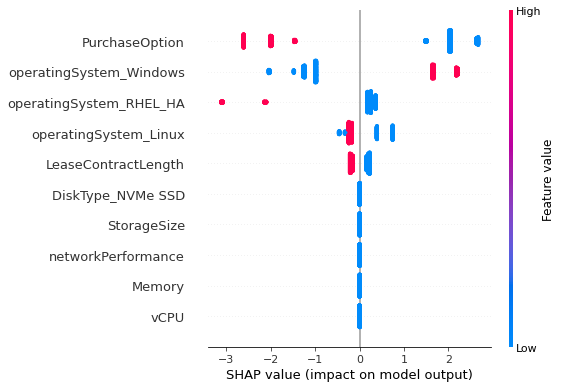

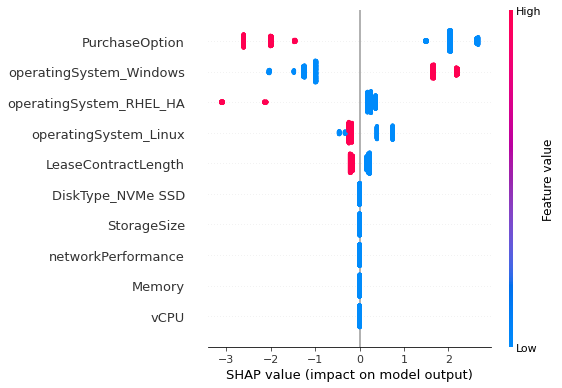

In [344]:
# Exclude the constant offset column from shap_values
shap_values = shap_values[:, :-1]

# Create a SHAP summary plot
shap.summary_plot(shap_values, X_valid)

# Save the plot as an artifact in MLflow
shap_plot_path = 'shap_summary_plot.png'
shap.summary_plot(shap_values, X_valid, show=False)
plt.savefig(shap_plot_path)
mlflow.log_artifact(shap_plot_path)

## Predictions vs Actual Prices

In [345]:

data_pred = data_pred.drop(
    ['instanceType'], axis=1)

data_pred = data_pred.reset_index(drop=True)

In [346]:
data_pred

,PricePerUnit,LeaseContractLength,PurchaseOption,vCPU,Memory,networkPerformance,EffectiveDate,StorageSize,year,operatingSystem_Linux,operatingSystem_RHEL_HA,operatingSystem_Windows,DiskType_NVMe SSD
0,28.695,3,0,72,144,25.0,2022-01-01,1800,2022,1,0,0,1
1,32.007,3,0,72,144,25.0,2022-01-01,1800,2022,0,0,1,1
2,33.425,1,0,72,144,25.0,2022-01-01,1800,2022,0,0,1,1
3,32.784,1,0,72,144,25.0,2022-01-01,1800,2022,0,0,1,1
4,15.941,3,1,72,144,25.0,2022-01-01,1800,2022,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,5.985,1,1,72,144,25.0,2022-10-01,1800,2022,1,0,0,1
700,10.539,3,0,72,144,25.0,2022-10-01,1800,2022,1,0,0,1
701,12.137,1,0,72,144,25.0,2022-10-01,1800,2022,1,0,0,1
702,5.167,3,1,72,144,25.0,2022-10-01,1800,2022,1,0,0,1


In [347]:
predictions = model.predict(data_pred)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

# Log the predictions CSV file as an artifact in MLflow
mlflow.log_artifact('predictions.csv', 'predictions')

In [348]:
predictions

array([ 8.19522876, 13.45600687, 13.79665314, 13.79665314,  7.20039919,
        4.48002158,  8.19522876, 13.45600687,  7.20039919,  7.47633382,
        7.47633382,  7.47633382, 13.79665314, 13.79665314,  7.20039919,
        4.48002158,  7.20039919, 13.79665314, 13.79665314, 13.45600687,
        7.47633382, 13.45600687,  7.47633382, 13.45600687,  7.47633382,
        4.88736763,  8.19522876,  8.71841423,  8.71841423,  4.48002158,
       13.45600687,  7.20039919,  7.20039919,  7.47633382,  7.20039919,
        7.47633382, 13.79665314, 13.79665314,  7.20039919,  7.47633382,
        7.20039919, 13.79665314, 13.79665314, 13.45600687,  7.47633382,
       13.45600687,  4.88736763,  7.20039919,  2.16622847,  4.88736763,
        4.88736763,  8.19522876,  8.71841423,  8.71841423,  4.48002158,
        7.20039919,  7.47633382,  7.47633382,  4.48002158, 13.45600687,
       13.79665314,  7.20039919,  8.19522876,  4.48002158,  8.71841423,
        8.71841423,  8.19522876,  4.88736763,  4.88736763, 13.79

In [349]:
actual_prices = data_pred.PricePerUnit

In [350]:

import plotly.graph_objects as go

# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(actual_prices))),
              y=actual_prices, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=list(range(len(predictions))),
              y=predictions, mode='lines', name='Predicted'))

fig.update_layout(
    title='Actual vs. Predicted Prices for 2022',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price')
)

# fig.show()

# Save the Plotly figure as an HTML file
html_path = "actual_predicted.html"
pio.write_html(fig, html_path)

# Log the HTML file as an artifact in MLflow
mlflow.log_artifact(html_path)

In [351]:
rmse = mean_squared_error(actual_prices, predictions, squared=False)

In [352]:
rmse

7.7296526980587705

In [353]:
error = actual_prices - predictions

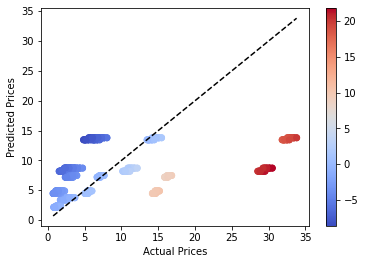

In [354]:
plt.scatter(actual_prices, predictions, c=error, cmap='coolwarm')
plt.plot(np.linspace(min(actual_prices), max(actual_prices), 100), np.linspace(
    min(actual_prices), max(actual_prices), 100), color='black', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.colorbar()
plt.show()

In [355]:
# Create a scatter plot using Plotly
fig = go.Figure(data=go.Scatter(
    x=actual_prices,
    y=predictions,
    mode='markers',
    marker=dict(
        size=8,
        color=error,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Error')
    )
))

fig.update_layout(
    title='Actual vs. Predicted Prices',
    xaxis=dict(title='Actual Prices'),
    yaxis=dict(title='Predicted Prices')
)

# fig.show()

# Save the Plotly figure as an HTML file
html_path = "actual_predicted_errors.html"
pio.write_html(fig, html_path)

# Log the HTML file as an artifact in MLflow
mlflow.log_artifact(html_path)

In [356]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

In [357]:
mlflow.log_metric("MSE", mse)
mlflow.log_metric("RMSE", rmse)
mlflow.log_metric("MAE", mae)
mlflow.log_metric("R-squared", r2)
# mlflow.log_metric()

In [358]:
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

MSE: 59.747530832607225
RMSE: 7.7296526980587705
MAE: 5.675605759150272
R-squared: 0.20829314708932434


https://towardsdatascience.com/ad-demand-forecast-with-catboost-lightgbm-819e5073cd3e

https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

In [359]:
# End the MLflow run
mlflow.end_run()